## Import libraries

In [47]:
import warnings
warnings.filterwarnings('ignore')

# Import functions and reload the module after making changes
from scripts import utilities
import importlib
importlib.reload(utilities)
from scripts.utilities import read_shapefile, check_transform_crs


#General libraries
import pandas as pd
import geopandas as gdp

#Plotting
import matplotlib.pyplot as plt

## Basic exploration of datasets

In [40]:
path = "datasets\shp\critical_minerals.shp"
CM = read_shapefile(path)
CM=check_transform_crs(CM)
CM.head(2)

Shapefile loaded with 270 records
Columns: 21
Geometry type: ['Point']


,OBJECTID,OperationG,Operatio_1,PropertyNa,Property_1,OperatorOw,Operator_1,ProvincesE,ProvincesF,Commoditie,...,Developmen,Developm_1,ActivitySt,Activity_1,Latitude,Longitude,Website,ID,EA_Status,geometry
0,1,Mine,Mine,LaRonde,LaRonde,Agnico Eagle Mines Limited,Mines Agnico Eagle Limitée,Quebec,Québec,"Gold, zinc, copper, silver, cadmium",...,Mine,Mine,Active,En activité,48.2516,-78.428,https://agnicoeagle.com,1,None,POINT (1220400.873 76541.162)
1,2,Mine,Mine,Mount Brussilof,Mount Brussilof,Baymag Inc.,Baymag Inc.,British Columbia,Colombie-Britannique,"Magnesite (fused), magnesia (products)",...,Mine,Mine,Active,En activité,50.7887,-115.683,https://baymag.com,2,None,POINT (-1423534.596 431796.427)


### Admin boundaries

In [53]:
path2 = r'datasets\shp\admin_boundaries.shp'
admin = read_shapefile(path2)

Shapefile loaded with 13 records
Columns: 7
Geometry type: ['MultiPolygon' 'Polygon']


,PRUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,geometry
0,59,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,"MULTIPOLYGON (((-123.53977 48.31735, -123.5397..."
1,24,Quebec / Québec,Quebec,Québec,Que.,Qc,"MULTIPOLYGON (((-74.63814 44.99984, -74.63859 ..."
2,62,Nunavut,Nunavut,Nunavut,Nvt.,Nt,"MULTIPOLYGON (((-79.99352 51.27725, -79.99475 ..."
3,11,Prince Edward Island / Île-du-Prince-Édouard,Prince Edward Island,Île-du-Prince-Édouard,P.E.I.,Î.-P.-É.,"MULTIPOLYGON (((-62.49302 46.02515, -62.49337 ..."
4,47,Saskatchewan,Saskatchewan,Saskatchewan,Sask.,Sask.,"POLYGON ((-102.00000 60.00000, -102.00000 59.9..."
5,60,Yukon,Yukon,Yukon,Y.T.,Yn,"MULTIPOLYGON (((-136.47224 68.89388, -136.4705..."
6,46,Manitoba,Manitoba,Manitoba,Man.,Man.,"MULTIPOLYGON (((-95.15588 49.59155, -95.15657 ..."
7,35,Ontario,Ontario,Ontario,Ont.,Ont.,"MULTIPOLYGON (((-82.68871 41.68453, -82.68631 ..."
8,13,New Brunswick / Nouveau-Brunswick,New Brunswick,Nouveau-Brunswick,N.B.,N.-B.,"MULTIPOLYGON (((-66.76541 44.58377, -66.76462 ..."
9,61,Northwest Territories / Territoires du Nord-Ouest,Northwest Territories,Territoires du Nord-Ouest,N.W.T.,T.N.-O.,"MULTIPOLYGON (((-133.43943 68.78677, -133.4430..."


<Axes: >

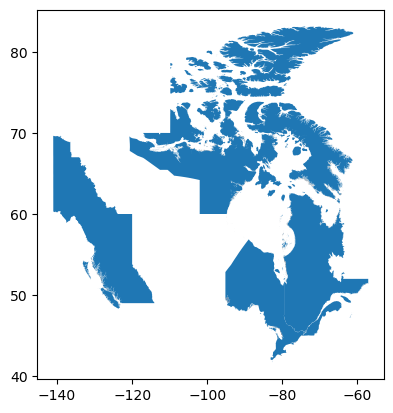

In [54]:
target_province=admin[admin['PRENAME'].isin(['British Columbia','Nunavut','Ontario','Quebec','Yukon'])]
target_province.plot()

### Geoquem

Esperare a ver que dicen el paper sobre cual es la forma de explorar CM en sedimentos, son >65K muestras es inviable ahora.

In [34]:
# geoquem=pd.read_excel(r'datasets\rgs2020_data.xlsx')
# geoquem.head(2)

,MASTERID,ORIGINAL_REP,UPDATE_REP1,UPDATE_REP2,UPDATE_REP3,NAME,TYPE2,MAP250,MAP50,MAP20,...,W_INA_PPM,Yb_INA_PPM,Zn_INA_PPM,Zr_INA_PPM,WT_INA_g,pH,Uw_LIF_PPB,Fw_ISE_PPB,SO4_TRB_PPM,Cnd_uS/cm
0,ID082E091379,GBC 2010-13,NaN,NaN,NaN,QUEST SOUTH,STRM,082E,082E13,082E.091,...,-1.0,-2.0,NaN,220.0,44.58,7.80,NaN,19.0,NaN,17.0
1,ID082E091380,GBC 2010-13,NaN,NaN,NaN,QUEST SOUTH,STRM,082E,082E13,082E.091,...,-1.0,-2.0,NaN,-200.0,39.18,7.58,NaN,19.0,NaN,18.0


<Axes: >

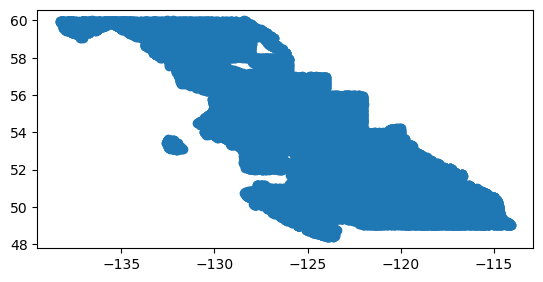

In [57]:
# ## Converting into GeoDataframe
# from shapely.geometry import Point
# geometry = [Point(xy) for xy in zip(geoquem['LONG'], geoquem['LAT'])]
# geoquem_geo = gdp.GeoDataFrame(geoquem, geometry=geometry)
# geoquem_geo.set_crs(epsg=4326, inplace=True)

#### Filtered data

In [60]:
# target_geoquem = geoquem_geo[geoquem_geo.within(target_province.unary_union)]
# # target_geoquem.plot()

## British Columbia

In [2]:
bc= read_shapefile('datasets\shp\BC_bedrock_ll83.shp')

Shapefile loaded with 35424 records
Columns: 28
Geometry type: ['Polygon']


,gid,upid,area_m2,strat_unit,era,period,strat_age,strat_name,gp_suite,fm_lithodm,...,terrane,basin,basin_age,project,src_url,src_ref_s,map_comp,edit_date,pub_org,geometry
0,32899,3a407beb,26984024.0,DPBC,Paleozoic,Devonian to Permian,Upper Devonian to Permian,Big Creek Group,Big Creek Group,None,...,Cassiar,None,None,QUEST,http://cmscontent.nrs.gov.bc.ca/geoscience/Pub...,"Logan et al., 2010, QUEST, BCGS, Geoscience Ma...","Logan et al., 2010, QUEST",2019-12-19,British Columbia Geological Survey,"POLYGON ((-125.41228 56.38084, -125.40884 56.3..."
1,32177,21fc6d71,10387807.0,KTgr,Mesozoic to Cenozoic,Cretaceous to Neogene,Cretaceous to Tertiary,None,None,None,...,Post Accretionary,None,None,QUEST,http://cmscontent.nrs.gov.bc.ca/geoscience/Pub...,"Logan et al., 2010, QUEST, BCGS, Geoscience Ma...","Logan et al., 2010, QUEST",2019-12-19,British Columbia Geological Survey,"POLYGON ((-125.38060 56.34913, -125.40884 56.3..."
2,32485,04faa7c9,22848228.0,EJHD,Mesozoic,Jurassic,Early Jurassic,Hogem Plutonic Suite - Duckling Creek Syenite ...,Hogem Plutonic Suite,Duckling Creek Syenite Complex,...,Quesnellia,None,None,QUEST,http://cmscontent.nrs.gov.bc.ca/geoscience/Pub...,"Logan et al., 2010, QUEST, BCGS, Geoscience Ma...","Logan et al., 2010, QUEST",2019-12-19,British Columbia Geological Survey,"POLYGON ((-125.35456 55.90206, -125.35376 55.8..."
3,32151,f8866709,697704236.0,EJHqm,Mesozoic,Jurassic,Early Jurassic,Hogem Plutonic Suite,Hogem Plutonic Suite,None,...,Quesnellia,None,None,QUEST,http://cmscontent.nrs.gov.bc.ca/geoscience/Pub...,"Logan et al., 2010, QUEST, BCGS, Geoscience Ma...","Logan et al., 2010, QUEST",2019-12-19,British Columbia Geological Survey,"POLYGON ((-125.35277 55.89660, -125.35376 55.8..."
4,32509,9b665cb2,463413.0,EJHD,Mesozoic,Jurassic,Early Jurassic,Hogem Plutonic Suite - Duckling Creek Syenite ...,Hogem Plutonic Suite,Duckling Creek Syenite Complex,...,Quesnellia,None,None,QUEST,http://cmscontent.nrs.gov.bc.ca/geoscience/Pub...,"Logan et al., 2010, QUEST, BCGS, Geoscience Ma...","Logan et al., 2010, QUEST",2019-12-19,British Columbia Geological Survey,"POLYGON ((-125.38981 55.90422, -125.38777 55.9..."


Simplyfing map by rock_class  + CM within BC province

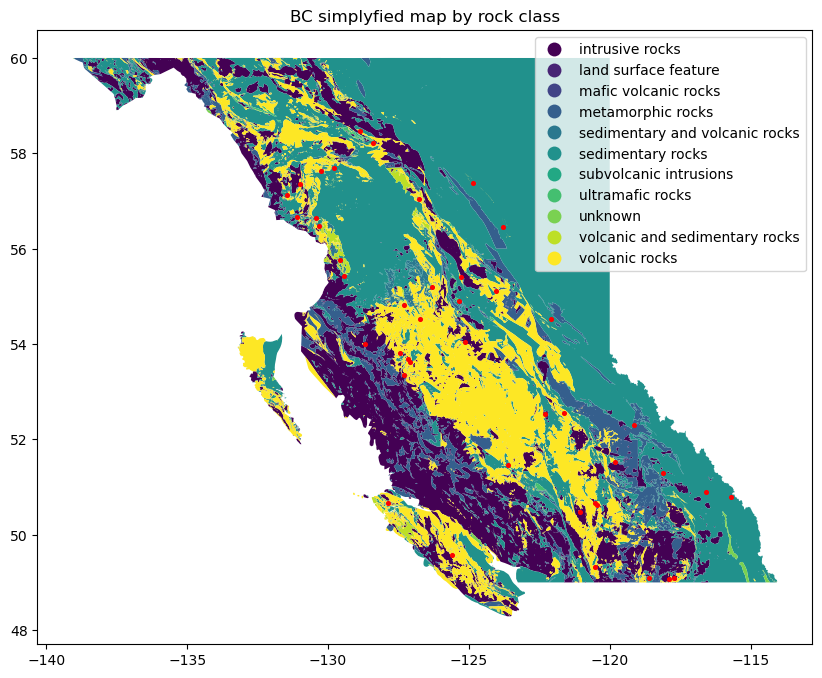

In [58]:
# bc_rocks=bc.dissolve(by='rock_class')
# bc_rocks.reset_index(inplace=True) 

# #Intersect CM points with BC polygons
# bc_cm=gdp.sjoin(CM,bc_rocks, how='inner', op='within')


fig, ax = plt.subplots(figsize=(10,10))
bc_rocks.plot(ax=ax, column='rock_class', legend=True, cmap='viridis')
bc_cm.plot(ax=ax, column ='OperationG',color ='red', marker = 'o', markersize = 7)
plt.title('BC simplyfied map by rock class')
plt.show()

In [57]:
len(bc_cm['Commoditie'].unique())

32